1_Solving high-dimensional partialdifferential equations using deep learning.pdf



100维 Allen-Cahn 方程

$$
\large  \frac{\partial u}{\partial t}(t,x) - \Delta u(t,x) - u(t,x) + [u(t,x)]^3, t\in [0,T],x\in \mathbb{R}^{100},\\
\large  u(0,x) = g(x),\\
\large  g(x) = \frac{1}{2+0.4||x||^2}.\\
$$

In [ ]:
n_dim = 100

T = 1

In [1]:
import deepxde as dde
from deepxde.backend import tf

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



In [ ]:
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, T)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

In [ ]:
def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t - dy_xx - y + y**3


def pde(x, y):
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t + y * dy_x - 0.01 / np.pi * dy_xx

def pde(x, y):
    dy_x = tf.gradients(y, x)[0]
    dy_x, dy_t = dy_x[:, 0:1], dy_x[:, 1:]
    dy_xx = tf.gradients(dy_x, x)[0][:, 0:1]
    dy_xxx = tf.gradients(dy_xx, x)[0][:, 0:1]
    return dy_t + lambda_1*y*dy_x +  lambda_2*dy_xxx

In [ ]:
ic = dde.icbc.IC(geomtime, 
                 lambda x: 1.0/(2.0+ 0.4*tf.reduce_sum(tf.square(x[:, 0:n_dim]), 1, keepdims=True)), 
                 lambda _, on_initial: on_initial)

data = dde.data.TimePDE(geomtime, pde, [ic],
                        num_domain=2540, num_boundary=80, num_initial=160)

In [ ]:
net = dde.nn.FNN([n_dim+1] + [200] * 3 + [1], "tanh", "Glorot normal")

In [ ]:
model = dde.Model(data, net)
model.compile("adam", lr=1e-3)

In [ ]:
## https://github.com/frankhan91/DeepBSDE/blob/master/equation.py

class AllenCahn():
    """Allen-Cahn equation in PNAS paper doi.org/10.1073/pnas.1718942115"""
    def __init__(self):
        self.dim = 100
        self.total_time = 0.3
        self.num_time_interval = 20
        self.delta_t = self.total_time / self.num_time_interval
        self.sqrt_delta_t = np.sqrt(self.delta_t)
        self.y_init = None
        # ---------------------------
        self.x_init = np.zeros(self.dim)
        self.sigma = np.sqrt(2.0)

    def sample(self, num_sample):
        """Sample forward SDE."""
        dw_sample = np.random.normal(size=[num_sample, self.dim, self.num_time_interval]) * self.sqrt_delta_t
        x_sample = np.zeros([num_sample, self.dim, self.num_time_interval + 1])
        x_sample[:, :, 0] = np.ones([num_sample, self.dim]) * self.x_init
        for i in range(self.num_time_interval):
            x_sample[:, :, i + 1] = x_sample[:, :, i] + self.sigma * dw_sample[:, :, i]
        return dw_sample, x_sample

    def f_tf(self, t, x, y, z):
        """Generator function in the PDE."""
        return y - tf.pow(y, 3)

    def g_tf(self, t, x):
        """Terminal condition of the PDE."""
        return 0.5 / (1 + 0.2 * tf.reduce_sum(tf.square(x), 1, keepdims=True))

In [ ]:
losshistory, train_state = model.train(epochs=15000)

Black-Scholes 方程


equ3.3Black-Scholes.py

In [1]:
import numpy as np
import tensorflow as tf
from scipy.stats import multivariate_normal as normal
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
import time
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt

In [2]:
class Y_compute(Layer):
    def __init__(self,dimension):
        self.dimension=dimension
        self.y_init = tf.Variable(np.random.uniform(size=[1]))
        self.grad_init = tf.Variable(
            np.random.uniform(size=[1, self.dimension]))
        super(Y_compute, self).__init__()

    def call(self, inputs, **kwargs):
        all_one_vec = tf.ones_like(tf.reduce_sum(tf.reduce_sum(inputs, axis=1), axis=1, keepdims=True))
        y = all_one_vec * self.y_init
        grad = tf.matmul(all_one_vec, self.grad_init)
        return y,grad

In [3]:
class BSDE():
    def __init__(self):
        self.dimension =100
        self.T = 1.0
        self.partion = 20
        self.interval = self.T / self.partion
        self.sqrt_interval = np.sqrt(self.interval)
        self.time_stamp = np.arange(0, self.partion) * self.interval
        self.x_init = np.zeros(self.dimension)
        self.rate = 0.02  # interest rate R
        self.delta = 2.0 / 3
        self.gammah = 0.2
        self.gammal = 0.02
        self.mu_bar = 0.02
        self.vh = 50.0
        self.vl = 70.0
        self.slope = (self.gammah - self.gammal) / (self.vh - self.vl)

    # f in the equation
    def f_equ(self, t, x, y, grad):
        piecewise_linear = tf.nn.relu(
            tf.nn.relu(y - self.vh) * self.slope + self.gammah - self.gammal) + self.gammal
        return (-(1 - self.delta) * piecewise_linear - self.rate) * y

    # Final
    def g_final(self, t, x):
        return tf.reduce_min(x, 1, keepdims=True)

    # Data generator with motion of X
    def sample(self, num_sample):
        dw_sample = normal.rvs(size=[num_sample, self.dimension,
                                     self.partion]) * self.sqrt_interval
        x_sample = np.zeros([num_sample, self.dimension, self.partion + 1])
        x_sample[:, :, 0] = np.ones([num_sample, self.dimension]) * self.x_init
        for i in range(self.partion):
            x_sample[:, :, i + 1] = x_sample[:, :, i] + dw_sample[:, :, i]

        y_true=self.g_final(self.T, x_sample[:, :, -1])
        return x_sample,dw_sample,y_true


    def part(self,x,num_hid=110,dup=2):
        for i in range(dup):
            x=Dense(num_hid,activation='relu')(x)
            x=BatchNormalization(
                momentum=0.99,
                epsilon=1e-6,
                beta_initializer=tf.random_normal_initializer(0.0, stddev=0.1),
                gamma_initializer=tf.random_uniform_initializer(0.1, 0.5)
            )(x)
        x = Dense(self.dimension, activation='relu')(x)
        return x

    def init_model(self,):
        x1=Input(shape=(self.dimension,self.partion+1))
        dw=Input(shape=(self.dimension,self.partion))

        y,grad=Y_compute(self.dimension)(x1)

        for t in range(0, self.partion-1):
            y = y - self.interval * (
                self.f_equ(self.time_stamp[t], x1[:, :, t], y, grad))
            grad = self.part(x1[:, :, t+1])

        # terminal time
        out = y - self.interval * self.f_equ(self.time_stamp[-1], x1[:, :, -2], y, grad)

        model=Model(inputs=[x1,dw],outputs=out)
        model.compile(loss='mse',optimizer='sgd')
        return model

In [16]:
tf.keras.backend.set_floatx('float64')
bsde=BSDE()

model=bsde.init_model()
x1_valid,x2_valid,y_valid = bsde.sample(256)

In [17]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 100, 21)]    0                                            
__________________________________________________________________________________________________
y_compute_1 (Y_compute)         ((None, 1), (None, 1 101         input_3[0][0]                    
__________________________________________________________________________________________________
tf.math.subtract_80 (TFOpLambda (None, 1)            0           y_compute_1[0][0]                
__________________________________________________________________________________________________
tf.nn.relu_40 (TFOpLambda)      (None, 1)            0           tf.math.subtract_80[0][0]        
____________________________________________________________________________________________

In [23]:
# tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

# tf 和 keras 混用，报错：
# AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute '_keras_history'

In [8]:
losses,ys=[],[]
start_time = time.time()

# begin SGD iteration
for step in range(3001):
    x1_train,x2_train,y_train = bsde.sample(64)
    model.train_on_batch([x1_train,x2_train], y_train)


    y_pred = model.predict_on_batch([x1_valid, x2_valid])
    loss = mean_squared_error(y_valid, y_pred)
    y_init=model.get_layer('y_compute').get_weights()[0]
    if step % 100 == 0:  # trace in terminal
        elapsed_time = time.time() - start_time
        print("step: %5u,    loss: %.4e, Y_init: %.4e,   elapsed time: %3u" %
              (step, loss, y_init, elapsed_time))
    losses.append(round(loss,4))
    ys.append(np.round(y_init, 4))
print('Done!!')

step:     0,    loss: 1.0133e+01, Y_init: 5.8570e-01,   elapsed time: 246
step:   100,    loss: 2.5218e-01, Y_init: -2.0426e+00,   elapsed time: 251
step:   200,    loss: 1.6849e-01, Y_init: -2.2797e+00,   elapsed time: 255
step:   300,    loss: 1.6774e-01, Y_init: -2.2935e+00,   elapsed time: 259
step:   400,    loss: 1.6776e-01, Y_init: -2.2930e+00,   elapsed time: 263
step:   500,    loss: 1.6749e-01, Y_init: -2.3027e+00,   elapsed time: 267
step:   600,    loss: 1.6755e-01, Y_init: -2.2998e+00,   elapsed time: 271
step:   700,    loss: 1.6751e-01, Y_init: -2.3017e+00,   elapsed time: 275
step:   800,    loss: 1.6747e-01, Y_init: -2.3039e+00,   elapsed time: 279
step:   900,    loss: 1.6775e-01, Y_init: -2.2934e+00,   elapsed time: 283
step:  1000,    loss: 1.6746e-01, Y_init: -2.3138e+00,   elapsed time: 287
step:  1100,    loss: 1.6747e-01, Y_init: -2.3041e+00,   elapsed time: 291
step:  1200,    loss: 1.6754e-01, Y_init: -2.3002e+00,   elapsed time: 295
step:  1300,    loss: 1.67

In [11]:
def draw_scatter(x,y,x_name,y_name):
    # 创建画图窗口
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title('{} with {}'.format(y_name,x_name))
    ax.set_xlabel(x_name)
    ax.set_ylabel(y_name)
    ax.scatter(x, y,marker='.',s=1)
    # plt.savefig(r'{} with {}.jpg'.format(y_name,x_name))
    plt.show()

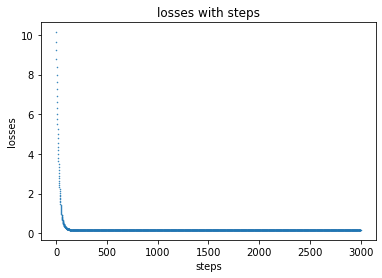

In [12]:
draw_scatter(list(range(3001)), losses, 'steps', 'losses')

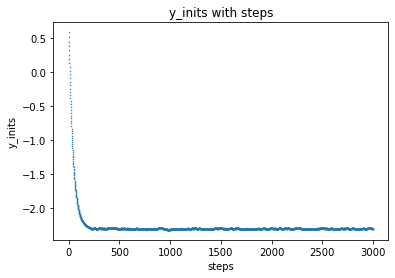

In [13]:
draw_scatter(list(range(3001)), ys, 'steps', 'y_inits')

equ4.4Pricing of European.py

In [1]:
import numpy as np
import tensorflow as tf
from scipy.stats import multivariate_normal as normal
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
import time
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt

tf.keras.backend.set_floatx('float64')

In [2]:
class Y_compute(Layer):
    def __init__(self,dimension):
        self.dimension=dimension
        self.y_init = tf.Variable(np.random.uniform(size=[1]))
        self.grad_init = tf.Variable(
            np.random.uniform(size=[1, self.dimension]))
        super(Y_compute, self).__init__()

    def call(self, inputs, **kwargs):
        all_one_vec = tf.ones_like(tf.reduce_sum(tf.reduce_sum(inputs, axis=1), axis=1, keepdims=True))
        y = all_one_vec * self.y_init
        grad = tf.matmul(all_one_vec, self.grad_init)
        return y,grad

In [3]:
class BSDE():
    def __init__(self):
        self.dimension =100
        self.T = 1
        self.partion = 20
        self.interval = self.T / self.partion
        self.sqrt_interval = np.sqrt(self.interval)
        #Specifically
        #self.lambd = 1.0
        self.time_stamp = np.arange(0, self.partion) * self.interval
        #self.x_init = np.ones(self.dimension) * 100
        self.x_init = np.zeros(self.dimension)
        self.sigma = 0.2
        self.mu_bar = 0.06
        self.rl = 0.04
        self.rb = 0.06
        self.alpha = 1.0 / self.dimension

    # f in the equation
    def f_equ(self, t, x, y, grad):
        temp = tf.reduce_sum(grad, 1, keepdims=True) / self.sigma
        return -self.rl * y - (self.mu_bar - self.rl) * temp + (
                (self.rb - self.rl) * tf.maximum(temp - y, 0))

    # Final
    def g_final(self, t, x):
        temp = tf.reduce_max(x, 1, keepdims=True)
        return tf.maximum(temp - 120, 0) - 2 * tf.maximum(temp - 150, 0)

    # Data generator with motion of X
    def sample(self, num_sample):
        dw_sample = normal.rvs(size=[num_sample, self.dimension,
                                     self.partion]) * self.sqrt_interval
        x_sample = np.zeros([num_sample, self.dimension, self.partion + 1])
        x_sample[:, :, 0] = np.ones([num_sample, self.dimension]) * self.x_init
        factor = np.exp((self.mu_bar-(self.sigma**2)/2)*self.interval)
        for i in range(self.partion):
            x_sample[:, :, i + 1] = (factor * np.exp(self.sigma * dw_sample[:,:,i])) * x_sample[:,:,i]

        y_true=self.g_final(self.T, x_sample[:, :, -1])
        return x_sample,dw_sample,y_true


    def part(self,x,num_hid=110,dup=2):
        for i in range(dup):
            x=Dense(num_hid,activation='relu')(x)
            x=BatchNormalization(
                momentum=0.99,
                epsilon=1e-6,
                beta_initializer=tf.random_normal_initializer(0.0, stddev=0.1),
                gamma_initializer=tf.random_uniform_initializer(0.1, 0.5)
            )(x)
        x = Dense(self.dimension, activation='relu')(x)
        return x

    def init_model(self,):
        x1=Input(shape=(self.dimension,self.partion+1))
        dw=Input(shape=(self.dimension,self.partion))


        y,grad=Y_compute(self.dimension)(x1)

        for t in range(0, self.partion-1):
            y = y - self.interval * (
                self.f_equ(self.time_stamp[t], x1[:, :, t], y, grad))
            grad = self.part(x1[:, :, t+1])

        # terminal time
        out = y - self.interval * self.f_equ(self.time_stamp[-1], x1[:, :, -2], y, grad)

        model=Model(inputs=[x1,dw],outputs=out)
        model.compile(loss='mse',optimizer='adam')
        return model

In [4]:
def draw_scatter(x,y,x_name,y_name):
    # 创建画图窗口
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title('{} with {}'.format(y_name,x_name))
    ax.set_xlabel(x_name)
    ax.set_ylabel(y_name)
    ax.scatter(x, y,marker='.',s=1)
    plt.show()
    # plt.savefig(r'{} with {}.jpg'.format(y_name,x_name))

In [5]:
bsde=BSDE()
model=bsde.init_model()
x1_valid,x2_valid,y_valid = bsde.sample(256)
# print(x1_valid)

In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 21)]    0                                            
__________________________________________________________________________________________________
y_compute (Y_compute)           ((None, 1), (None, 1 101         input_1[0][0]                    
__________________________________________________________________________________________________
tf.math.reduce_sum (TFOpLambda) (None, 1)            0           y_compute[0][1]                  
__________________________________________________________________________________________________
tf.__operators__.getitem_1 (Sli (None, 100)          0           input_1[0][0]                    
______________________________________________________________________________________________

In [11]:
# tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [7]:
losses,ys=[],[]
start_time = time.time()

# begin SGD iteration
for step in range(3001):
    x1_train,x2_train,y_train = bsde.sample(64)
    model.train_on_batch([x1_train,x2_train], y_train)

    y_pred = model.predict_on_batch([x1_valid, x2_valid])
    loss = mean_squared_error(y_valid, y_pred)
    y_init=model.get_layer('y_compute').get_weights()[0]
    if step % 100 == 0:  # trace in terminal
        elapsed_time = time.time() - start_time
        print("step: %5u,    loss: %.4e, Y_init: %.4e,   elapsed time: %3u" %
              (step, loss, y_init, elapsed_time))
    losses.append(round(loss,4))
    ys.append(np.round(y_init, 4))
print('Done!!')

step:     0,    loss: 6.6036e-03, Y_init: 7.6537e-02,   elapsed time:  11
step:   100,    loss: 6.9330e-05, Y_init: 7.8423e-03,   elapsed time:  19
step:   200,    loss: 6.5531e-11, Y_init: 7.6244e-06,   elapsed time:  27
step:   300,    loss: 3.6176e-14, Y_init: 1.7914e-07,   elapsed time:  35
step:   400,    loss: 1.3086e-18, Y_init: -1.0774e-09,   elapsed time:  43
step:   500,    loss: 7.0929e-23, Y_init: -7.9322e-12,   elapsed time:  52
step:   600,    loss: 1.8934e-27, Y_init: -4.0965e-14,   elapsed time:  60
step:   700,    loss: 2.8507e-32, Y_init: -1.6884e-16,   elapsed time:  69
step:   800,    loss: 7.3954e-41, Y_init: 8.5997e-21,   elapsed time:  77
step:   900,    loss: 3.6505e-41, Y_init: 6.0419e-21,   elapsed time:  85
step:  1000,    loss: 7.6472e-49, Y_init: -8.7448e-25,   elapsed time:  94
step:  1100,    loss: 1.5670e-50, Y_init: -1.2518e-25,   elapsed time: 102
step:  1200,    loss: 6.9901e-55, Y_init: 8.3607e-28,   elapsed time: 111
step:  1300,    loss: 1.8817e-59

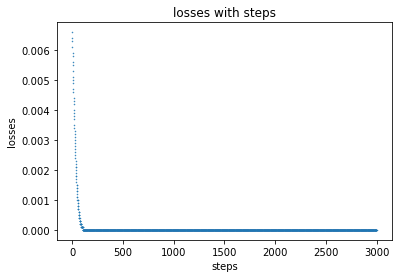

In [8]:
draw_scatter(list(range(3001)), losses, 'steps', 'losses')

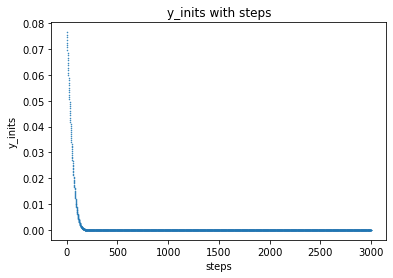

In [9]:
draw_scatter(list(range(3001)), ys, 'steps', 'y_inits')

In [12]:
x1_train,x2_train,y_train = bsde.sample(64)

In [15]:
x1_train.shape,x2_train.shape,y_train.shape

((64, 100, 21), (64, 100, 20), TensorShape([64, 1]))

In [16]:
x1_valid.shape, x2_valid.shape

((256, 100, 21), (256, 100, 20))